# MCMC using GerryChain

'GerryChain' is a python package created and made available by the MGGG redistricting lab (https://mggg.org/). The guide to the software, along with several examples of it in use can all be found on their GitHub repositry: https://github.com/mggg-states. Dr. Daryl Deford has also created some very interesting and useful programs to show how GerryChain works which can be found here: https://github.com/drdeford, along with an in depth guide walking you through building your own redistricting program: https://people.csail.mit.edu/ddeford//GerryChain_Guide.pdf.

The following sections of code are all run on Python 3 using the Anaconda distribution platform, and are displayed using jupyter notebook. Also note that the GerryChain package must be installed to run the program (https://gerrychain.readthedocs.io/en/latest/).

## Import packages

Firstly to use GerryChain, it must be imported along with all of it's required features (see below). Other packages I used for this project included matplotlib, functools, networkx and a random number generator (these are all included in the anaconda package).

In [1]:
from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator, 
    single_flip_contiguous, 
    within_percent_of_ideal_population, 
    UpperBound)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom

import random
import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

## Create area graph

For simplicity I have used a simple rectangular grid, instead of dual graph to represent the area to be partitioned. There are several features that can be edited here if you would like to see a different number of districts or a different graph (see notes beside code).

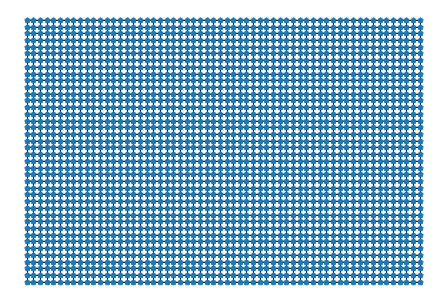

In [2]:
k_partitions = 8 # Number of districts
node_size = 30 # Size of each point on graph
grid_height = 40 # Number or nodes vertically
grid_width = 60 # Number of nodes horizontally

graph = nx.grid_graph([grid_height, grid_width])

plt.figure()
nx.draw(graph, pos={x: x for x in graph.nodes()}, node_size=node_size, node_shape="p")
plt.show()

## Apply voting data

Set up voting data, in this case this data is entirely random, however usually this would be real data. Also note that usually the data would not be as regularly dispersed as this example, instead we would see clusters around certain areas of high population and areas with a high tendency of voting for the same party. 

I have created to parties, party 1 (or P1) and party 2 (P2). The random_boundary variable is the chance of a vote being for party 1, hence in this sample we should roughly have a 50/50 split between P1 and P2 votes (however this can be changed to view different results). In the resulting grid the lighter nodes represent P1 votes, and the darker nodes show P2 votes. The vote is encoded in the graph via binary (value 1 is P1, and value 0 is P2), the program then decodes it via a simple dictionary function, vote_dict.

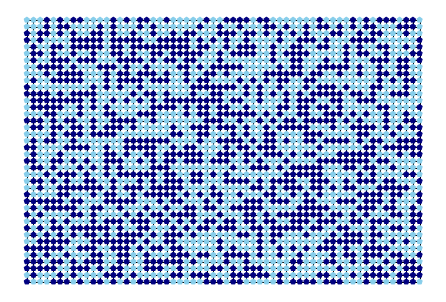

In [3]:
random_boundary = 0.50 # chance of party 1 vote
P1 = "skyblue"
P2 = "navy"

for node in graph.nodes():
    graph.nodes[node]["population"] = 1 # counts population

    if random.random() < random_boundary: # creates party 1 and 2 votes at random
        graph.nodes[node][P1] = 1
        graph.nodes[node][P2] = 0
    else:
        graph.nodes[node][P1] = 0
        graph.nodes[node][P2] = 1

vote_dict = {1: P1, 0: P2} # translates binary to votes

plt.figure() #plots grid figure
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[vote_dict[graph.nodes[x][P1]] for x in graph.nodes()],
    node_size=node_size,
    node_shape="p",
)
plt.show()

## Create initial partition

This section is where all the necessary functions are set up to allow the markov chains to function. Firstly the step number (step_num) so that the chain remembers each step it is at. Then the updaters, which are shown in one of Dr. Daryl Deford's examples (https://github.com/drdeford/GerryChain-Templates), these create the required variables for the chains so that theycan be updated at each step. Now the intial partition can be defined (see init_part) using these updaters. In this example each district is a simple verticle line each covering the same population of the grid. Similarly to the voting data, a dictionary is used to assign each node to a specific district.

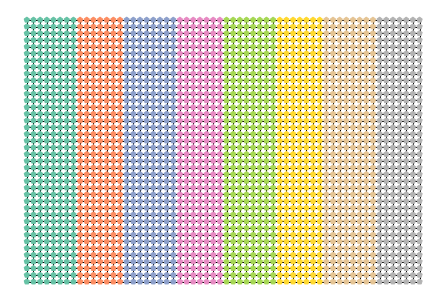

In [4]:
def step_num(partition):
    parent = partition.parent
    if not parent:
        return 0
    return parent["step_num"] + 1

updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    "step_num": step_num,
    "P1 vs P2": Election("P1 vs P2", {"P1": P1, "P2": P2}),
}

part_dict = {x: int(x[0]/(grid_width/k_partitions)) for x in graph.nodes()} # assigns each node to a district

init_part = Partition(graph, assignment=part_dict, updaters=updaters) # initial partition

plt.figure() # plots grid figure
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[part_dict[x] for x in graph.nodes()],
    node_size=node_size,
    node_shape="p",
    cmap="Set2",
)
plt.show()

## Set up functions for analysis

For analysing the amount of seats won I created functions, p1_wins and p2_wins taht use built in GerryChain functions to calculate the percentage of seats won by each party. The equal_check function I added for when a district contains exactly the same amount of votes for each party, in which case the percentage seats of that district is split 50/50.

In [5]:
def p1_wins(partition): # when called shows percentage of seats won by first party
    if partition["P1 vs P2"].wins("P1")+partition["P1 vs P2"].wins("P2") > k_partitions:
        return equal_check(partition, "P1")
    else:
        return (partition["P1 vs P2"].wins("P1")/k_partitions)*100

def p2_wins(partition): # when called shows percentage of seats won by second party
    if partition["P1 vs P2"].wins("P1")+partition["P1 vs P2"].wins("P2") > k_partitions:
        return equal_check(partition, "P2")
        #return ((partition["P1 vs P2"].wins("P2")/k_partitions)*100)-(100/k_partitions)/2
    else:
        return (partition["P1 vs P2"].wins("P2")/k_partitions)*100
    
def equal_check(partition, party): # gives disrtict 50/50 split if votes for each party are the same
    for number in range(1, k_partitions+1):
        if partition["P1 vs P2"].wins("P1")+partition["P1 vs P2"].wins("P2") == k_partitions + number:
            return ((partition["P1 vs P2"].wins(party)/k_partitions)*100)-((100/k_partitions)/2)*number
    raise error

## Create your constraints

Add whichever constraints you wish to in this section. I created a population constraint using GerryChain function (within_percent_of_ideal_population) to allow for only a 10% difference in population between districts and a constraint on cut edges (edges between districts) which sets an upper bound of 400 cut edges, this prevents getting incompact snaky appearing districts. Further constraints (such as contiguity) are built in functions thatcan be seen in the Markov chain later in this program.

In [6]:
ideal_population = sum(init_part["population"].values()) / len(init_part)
popbound = within_percent_of_ideal_population(init_part, 0.1) # population constraint
cutedgebound = UpperBound(lambda part: len(part["cut_edges"]), 400) # compactness constraint

## The Flip Markov chain

Now we create the chain. Flip Markov chains propose a random flip of edge nodes of each district at each step. If the proposal satisfies each of the constraints and is in the state space it is accepted and the chain moves to the next step. Otherwise the proposal is rejected and the chain remains at the state it was in. 

The number of steps is defined in the first line of this code section and can be changed to whatever you wish, however note that Flip chains require many steps to reach a steady state (i.e. to create a useful map).

In [7]:
flip_steps = 250000 # number of steps to be taken

flip_chain = MarkovChain(
    propose_random_flip, # proposal function
    Validator([single_flip_contiguous, popbound, cutedgebound]), # list of constraints
    accept = always_accept,
    initial_state = init_part,
    total_steps = flip_steps, 
)

Finally the chain is run, please be aware that as this chain requires many steps (approx. 150000 or more) it may take several minutes for the chain to reach completion. The following section of code displays the map evry fifth of the way to completion. Once completed the final election results of the last map will be shown.

Step 0:


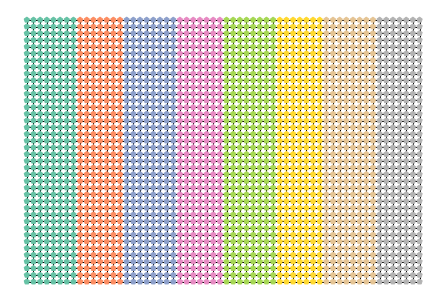

Step 50000:


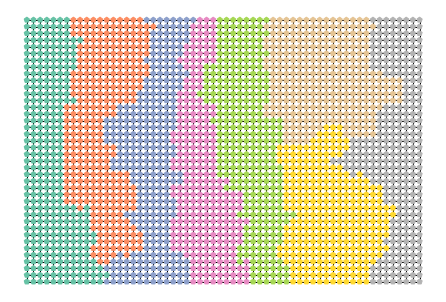

Step 100000:


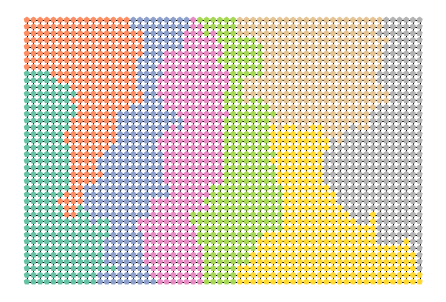

Step 150000:


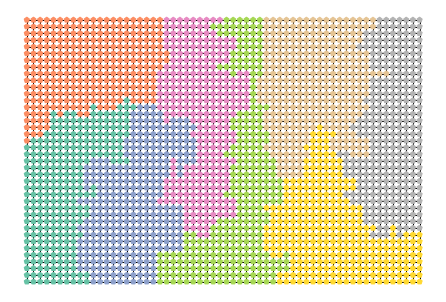

Step 200000:


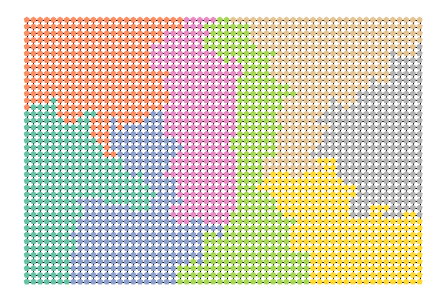

Step 250000:


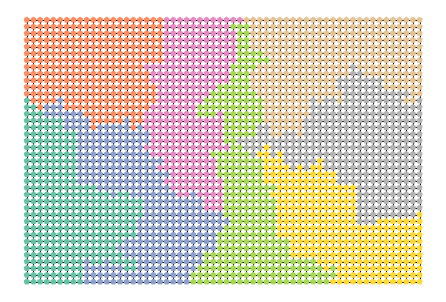

Election Results for P1 vs P2
0:
  P1: 0.4718
  P2: 0.5282
1:
  P1: 0.4983
  P2: 0.5017
2:
  P1: 0.4854
  P2: 0.5146
3:
  P1: 0.4982
  P2: 0.5018
4:
  P1: 0.5251
  P2: 0.4749
5:
  P1: 0.4695
  P2: 0.5305
6:
  P1: 0.5314
  P2: 0.4686
7:
  P1: 0.5123
  P2: 0.4877


In [8]:
flip_p1_seats = [] # records P1 seats

step_counter = 0 # records steps

print("Step " + str(step_counter) + ":")

plt.figure() # shows initial partition
nx.draw(
    graph,
    pos = {x: x for x in graph.nodes()},
    node_color = [part_dict[x] for x in graph.nodes()],
    node_size = node_size,
    node_shape = "p",
    cmap = "Set2",
)
plt.show()

for part in flip_chain: # runs flip chain
    step_counter = step_counter + 1
    flip_p1_seats.append(part["P1 vs P2"].wins("P1"))
    if step_counter % (flip_steps/5) == 0:
        print("Step " + str(step_counter) + ":")
        plt.figure() # prints map
        nx.draw(
            graph,
            pos = {x: x for x in graph.nodes()},
            node_color = [dict(part.assignment)[x] for x in graph.nodes()],
            node_size = node_size,
            node_shape = "p",
            cmap = "Set2",
        )
        plt.show()
    if step_counter % flip_steps == 0:
        print(part["P1 vs P2"])

## The ReCom Markov chain

The ReCom chain works differently to the Flip chain. The ReCom proposal function (see below) is far more complex. Rather than proposing a simple node flip, 2 connected districts are picked which are merged together before, via a spanning tree, a whole new partition between the two districts is made. 

In [9]:
tree_proposal = partial( # defines the proposal function
    recom,
    pop_col = "population",
    pop_target = ideal_population,
    epsilon = 0.1, # percentage of deviation from ideal population
    node_repeats = 1,
)

This new proposal function means that the chain runs much faster than the flip chain as it requires far less steps  to produce a suitable map (hence you will notice the time taken for it to run is much smaller). The complex proposal function also allows for the actual chain to have less constraints, in the following chain only uses the population constraint, however still manages to produce very succesful maps.

In [10]:
recom_steps = 100 # number of steps to be taken

recom_chain = MarkovChain(
    tree_proposal, # proposal function
    Validator([popbound]),
    accept = always_accept,
    initial_state = init_part,
    total_steps = recom_steps,
)

In this next section the chain is run. Notice how much quicker it is to the previous chain. Once again a map is printed each 5th of the way through the process, and atthe end a set of election results are shown.

Step 0:


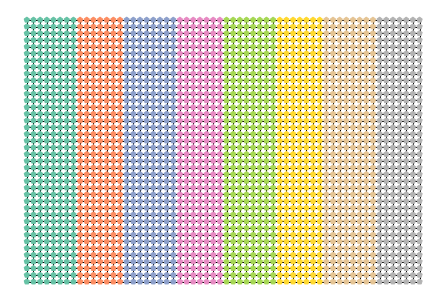

Step 20:


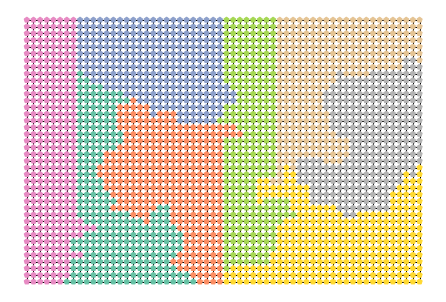

Step 40:


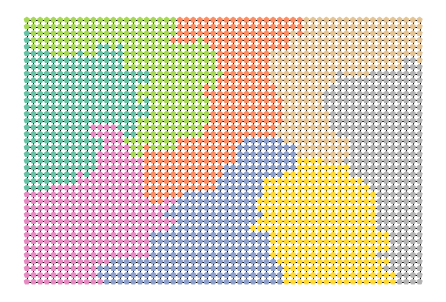

Step 60:


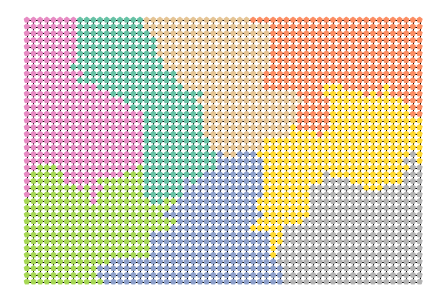

Step 80:


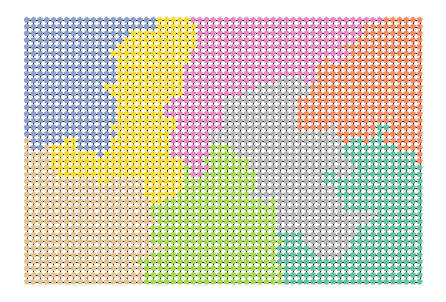

Step 100:


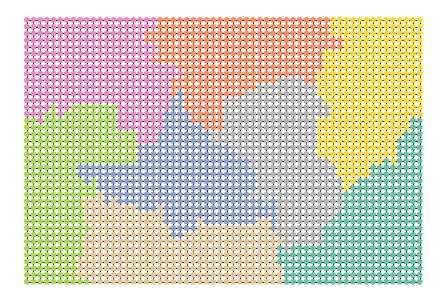

Election Results for P1 vs P2
0:
  P1: 0.4882
  P2: 0.5118
1:
  P1: 0.5084
  P2: 0.4916
2:
  P1: 0.4774
  P2: 0.5226
3:
  P1: 0.5
  P2: 0.5
4:
  P1: 0.483
  P2: 0.517
5:
  P1: 0.5426
  P2: 0.4574
6:
  P1: 0.5133
  P2: 0.4867
7:
  P1: 0.4795
  P2: 0.5205


In [11]:
recom_P1_seats = [] # records P1 seats
step_counter = 0 # records steps taken

print("Step " + str(step_counter) + ":")

plt.figure() # shows inital partition
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[part_dict[x] for x in graph.nodes()],
    node_size=node_size,
    node_shape="p",
    cmap="Set2",
)
plt.show()

for part in recom_chain: # runs recom chain
    step_counter = step_counter + 1
    recom_P1_seats.append(part["P1 vs P2"].wins("P1"))
    if step_counter % (recom_steps/5) == 0:
        print("Step " + str(step_counter) + ":")
        plt.figure() # prints map
        nx.draw(
            graph,
            pos = {x: x for x in graph.nodes()},
            node_color = [dict(part.assignment)[x] for x in graph.nodes()],
            node_size = node_size,
            node_shape = "p",
            cmap = "Set2",
        )
        plt.show()
        if step_counter % recom_steps == 0:
            print(part["P1 vs P2"])

## Outlier Analysis

To analyse plans an ensemble of many maps has to be made. Here I try to replicate the process using just 20 maps and letting each one run for just 50 steps. In a real scenario a far larger ensemble would be made, and each chain would be ran for many more steps. The following piece of code also shows the percentage of seats won by each party for each map.

In [14]:
seats_won = [] # makes a list of the P1 seat percentage of each map

for i in range(1, 21): # creates 10 maps
    seats_won.append(p1_wins(part)) # records P1 seats
    recom_P1_seats = []
    for part in recom_chain:
        recom_P1_seats.append(part["P1 vs P2"].wins("P1"))
    print("Map " + str(i) + ":")
    print(str(p1_wins(part)) + "% seats for first party")
    print(str(p2_wins(part)) + "% seats for second party")
    print(" ")

Map 1:
62.5% seats for first party
37.5% seats for second party
 
Map 2:
37.5% seats for first party
62.5% seats for second party
 
Map 3:
50.0% seats for first party
50.0% seats for second party
 
Map 4:
56.25% seats for first party
43.75% seats for second party
 
Map 5:
43.75% seats for first party
56.25% seats for second party
 
Map 6:
37.5% seats for first party
62.5% seats for second party
 
Map 7:
50.0% seats for first party
50.0% seats for second party
 
Map 8:
43.75% seats for first party
56.25% seats for second party
 
Map 9:
31.25% seats for first party
68.75% seats for second party
 
Map 10:
50.0% seats for first party
50.0% seats for second party
 
Map 11:
50.0% seats for first party
50.0% seats for second party
 
Map 12:
50.0% seats for first party
50.0% seats for second party
 
Map 13:
50.0% seats for first party
50.0% seats for second party
 
Map 14:
50.0% seats for first party
50.0% seats for second party
 
Map 15:
56.25% seats for first party
43.75% seats for second pa

Once we have our data collected in a list (seats_won) we can create a histogram of the results. This displays the percentage of seats won by P1 on the x-axis and the frequency on the y-axis. When using a large enough ensemble of maps the histogram will form a normal distribution, any outliers of this distribution can then be considered to be gerrymanders.

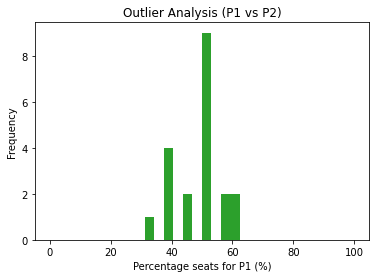

In [15]:
plt.plot(100, 2, 3)
plt.hist(seats_won)
plt.title("Outlier Analysis (P1 vs P2)")
plt.xlabel("Percentage seats for P1 (%)")
plt.ylabel("Frequency")
plt.show()